# Processo Seletivo - Cientista de Dados Jr - Americanas S.A.

In [10]:
import os
import warnings

import numpy                    as np
import pandas                   as pd
import seaborn                  as sns
import matplotlib.pyplot        as plt

from random                     import sample

from sklearn.preprocessing      import MinMaxScaler
from sklearn.model_selection    import RepeatedKFold
from sklearn.model_selection    import cross_val_score

from sklearn.svm                import SVC
from xgboost                    import XGBClassifier
from sklearn.linear_model       import LogisticRegression

from sklearn.pipeline           import Pipeline

from sklearn.decomposition      import PCA

from sklearn.metrics            import accuracy_score

sns.set(style='whitegrid')

warnings.filterwarnings("ignore")

In [11]:
PROJECT_DIR = os.path.dirname( os.getcwd() )

DATA_DIR = os.path.join(PROJECT_DIR, 'data/')

In [12]:
#carregando os dados
df = pd.read_parquet(DATA_DIR + 'dataset_cdjr.parquet', engine='pyarrow')

# Análise exploratória dos dados

## Análise univariada

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 337 to 92
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature0   466 non-null    float64
 1   feature1   466 non-null    int64  
 2   feature2   466 non-null    float64
 3   feature3   466 non-null    float64
 4   feature4   466 non-null    float64
 5   feature5   466 non-null    float64
 6   feature6   466 non-null    int64  
 7   feature7   466 non-null    float64
 8   feature8   466 non-null    float64
 9   feature9   466 non-null    int64  
 10  feature10  466 non-null    float64
 11  feature11  466 non-null    float64
 12  feature12  466 non-null    float64
 13  feature13  466 non-null    float64
 14  feature14  466 non-null    float64
 15  feature15  466 non-null    int64  
 16  target     466 non-null    int64  
dtypes: float64(12), int64(5)
memory usage: 65.5 KB


In [15]:
#Procurando por padrões nos dados
for col in df.columns:
  print(f'{col}: {(df[col].nunique())}\n')

feature0: 60

feature1: 30

feature2: 291

feature3: 458

feature4: 440

feature5: 343

feature6: 387

feature7: 466

feature8: 295

feature9: 465

feature10: 446

feature11: 289

feature12: 295

feature13: 286

feature14: 290

feature15: 56

target: 2



Observamos que há variáveis que possuem quase todos os valores distintos, algumas que possuem menos, ou seja, muitos valores se repetem, e algumas que possuem poucos valores distintos, que são as variáveis feature0, feature1 e feature15. Iremos analisar esses valores.

In [16]:
for col in ['feature0', 'feature1', 'feature15']:
  print(f'{col}: {np.unique(df[col])}\n')

feature0: [    0.      50.     100.     140.     150.     200.     250.     300.
   320.     350.     400.     430.     450.     500.     541.16   550.
   560.     600.     635.09   640.     650.     680.     700.     750.
   790.     800.     825.     850.     900.     950.     990.    1000.
  1050.    1100.    1160.    1200.    1250.    1300.    1350.    1359.
  1400.    1550.    1599.25  1600.    1850.    1940.    2000.    2010.
  2050.    2100.    2140.    2150.    2200.    2400.    2900.    3225.
  3680.    6600.    8240.   15400.  ]

feature1: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 25 26 27 28 30 31]

feature15: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  25  26  27  31  32  33  34  35  37  38  39  41
  43  45  47  51  54  62  68  71  81  83  84  92  94 105 118 136 144 153
 278 541]



Irei assumir que as variáveis feature1 e feature15 são variáveis categóricas que já foram codificadas, pois apresentam valores que dão a entender isso. A feature0 aparenta ser apenas uma variável numérica discreta.

Iremos corrigir o tipo de dados dessas duas variáveis

In [17]:
df[['feature1', 'feature15']] = df[['feature1', 'feature15']].astype('category')

Iremos guardar duas listas: uma com as variáveis categóricas e uma com as variáveis numéricas. Isso pode facilitar futuras análises.

In [18]:
features_categoricas = ['feature1', 'feature15']
features_numericas = df.drop(['feature1', 'feature15', 'target'], axis = 1).columns

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 466 entries, 337 to 92
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   feature0   466 non-null    float64 
 1   feature1   466 non-null    category
 2   feature2   466 non-null    float64 
 3   feature3   466 non-null    float64 
 4   feature4   466 non-null    float64 
 5   feature5   466 non-null    float64 
 6   feature6   466 non-null    int64   
 7   feature7   466 non-null    float64 
 8   feature8   466 non-null    float64 
 9   feature9   466 non-null    int64   
 10  feature10  466 non-null    float64 
 11  feature11  466 non-null    float64 
 12  feature12  466 non-null    float64 
 13  feature13  466 non-null    float64 
 14  feature14  466 non-null    float64 
 15  feature15  466 non-null    category
 16  target     466 non-null    int64   
dtypes: category(2), float64(12), int64(3)
memory usage: 62.9 KB


Nenhuma coluna possui valores nulos, então não é preciso se preocupar com isso. Agora, devemos explorar numericamente os dados. 

In [20]:
df.describe()

,feature0,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,target
count,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000,4.660000e+02,466.000000,466.000000,466.000000,466.000000,466.000000,466.000000
mean,438.743562,1244.322468,44.600880,-434.299893,0.473991,979.070815,0.113885,3.857010,2.164378e+05,6930.456438,0.437333,61.886190,0.008634,87.713360,0.557940
std,984.593065,3558.699033,122.093515,975.555198,0.452261,1460.738442,1.873746,15.609132,3.508622e+05,17581.800818,3.442094,142.521523,0.017866,145.426437,0.497165
min,0.000000,0.000000,-645.870000,-15506.350000,0.150000,1.000000,0.000663,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,-0.400000,-492.035000,0.173669,133.500000,0.003318,0.000000,2.113100e+04,383.687500,0.000000,0.000000,0.000000,0.000000,0.000000
50%,150.000000,169.830000,18.360000,-154.525000,0.303854,420.000000,0.005127,0.937082,8.532850e+04,1410.855000,0.082515,19.692568,0.003207,72.524286,1.000000
75%,500.000000,1017.375000,44.630000,-50.180000,0.569848,1238.750000,0.009699,2.815824,2.645035e+05,5212.977500,0.311311,65.498098,0.009515,127.301505,1.000000
max,15400.000000,40291.240000,1521.900000,-0.260000,3.150000,11731.000000,40.000000,281.666667,3.366472e+06,237182.780000,73.080634,2232.100000,0.204611,2154.000000,1.000000


Comparando algumas estatísticas básicas como valores mínimo e máximo, observamos que algumas variáveis estão em escalas bastante diferentes, então é necessário se atentar a isso futuramente, na hora de preparar os dados para um modelo de ML.

Outra observação é que a coluna 'target' tem a média acima de 0.5, ou seja, há mais observações com valor 1 do que com valor 0. Porém, não é uma diferença muito grande.

Ainda outra observação é que, ao observar em conjunto valor mínimo, máximo e média, algumas variáveis parecem ter outliers. Sendo asssim, vamos procurar por eles e tratá-los.

### Análise e tratamento de outliers

Inicialmente, vamos olhar a distribuição dos dados através do gráfico boxplot para ter uma noção visual dos outliers, que são representados por pontos além do "desenho" da caixa e de seus limites demarcados.

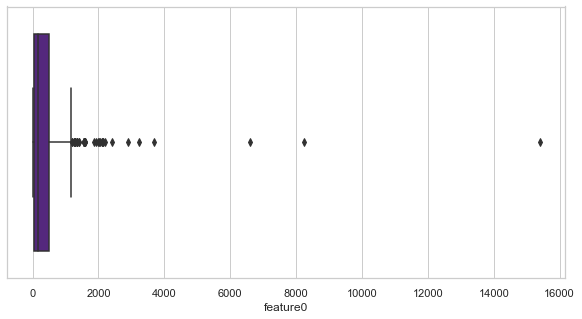

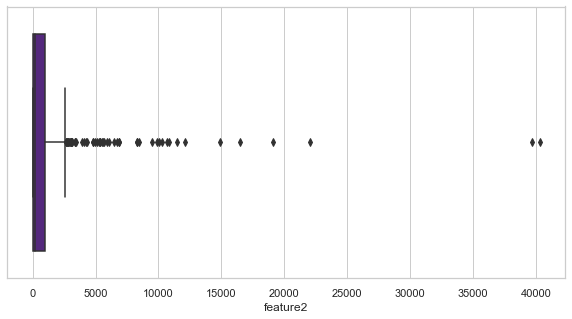

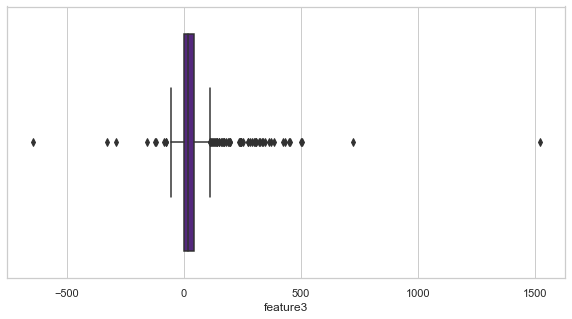

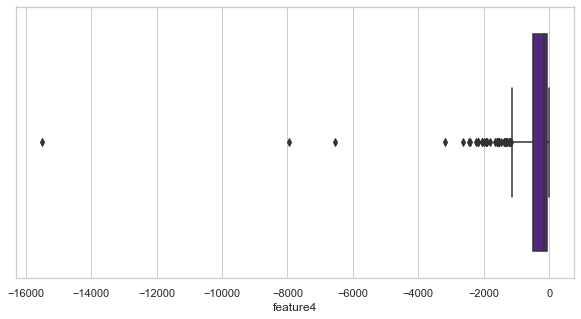

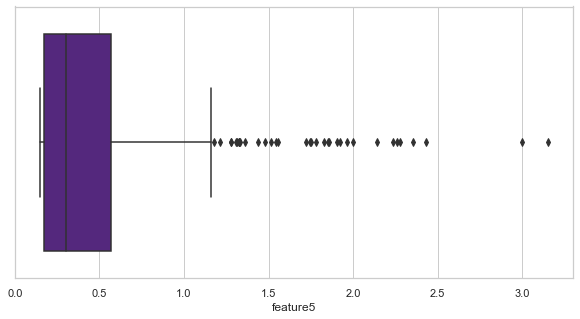

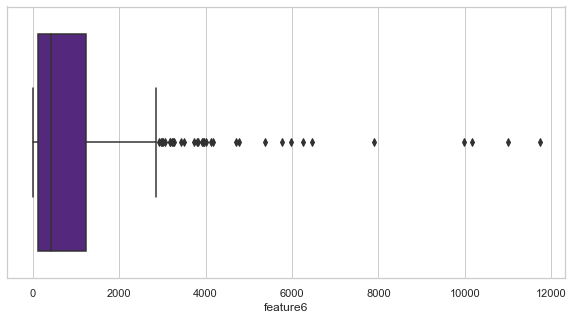

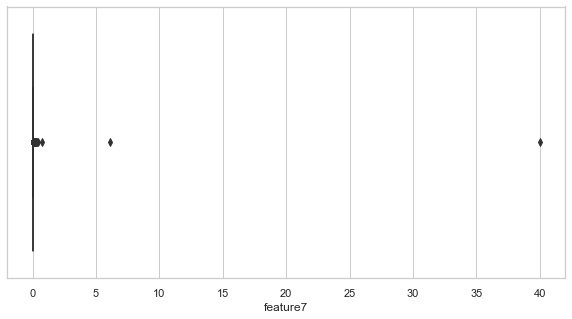

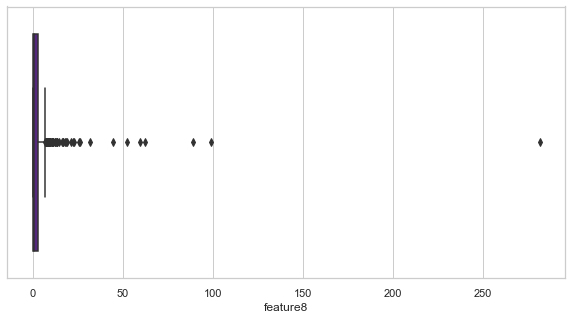

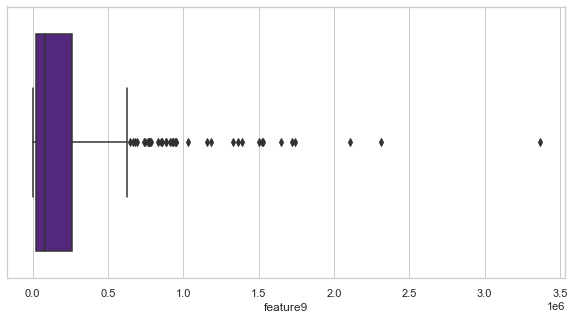

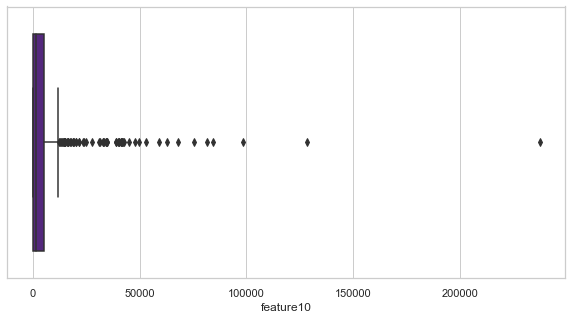

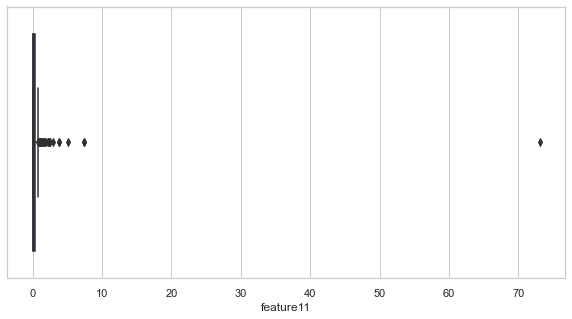

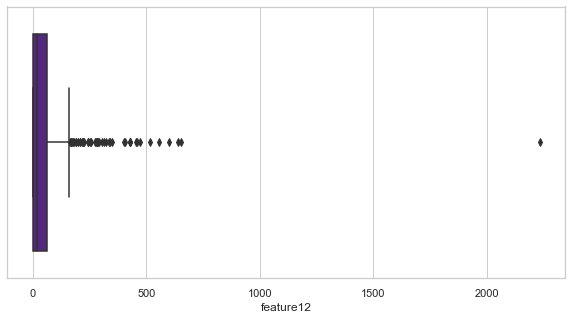

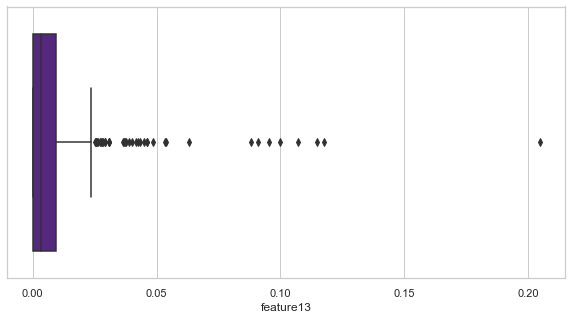

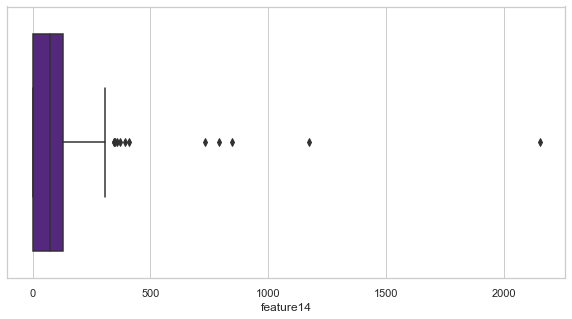

In [21]:
for column in features_numericas:
    plt.figure(figsize = (10, 5))
    sns.boxplot(x = df[column],
                color = '#551A8B')

Uma forma de encontrar quais são os outliers é através de uma análise estatística. Considerando nossos dados, temos algumas propriedades:

**Quartis:** cada quartil possui 25% da amostra. Consideramos Q1, Q2 e Q3; Q2 corresponde à mediana.

**Intervalo ou amplitude interquartil (I):** corresponde à região "coberta" pela caixa no gráfico boxplot: Q3 - Q1.

**Limite superior:** Q3 + (c * I)

**Limite inferior:** Q1 - (c * I)

*A constante c pode assumir qualquer valor, porém o mais utilizado na estatística é 1.5, sendo assim, é o que usaremos nessa análise.

Qualquer valor acima do limite superior ou abaixo do limite inferior é considerado outlier.

In [22]:
#Calculando o intervalo interquartil e os limites para cada feature
I = {col : np.percentile(df[col], 75) - np.percentile(df[col], 25) for col in features_numericas}

limites_superiores = {col : np.percentile(df[col], 75) + (1.5 * v) for col, v in I.items()}
limites_inferiores = {col : np.percentile(df[col], 25) - (1.5 * v) for col, v in I.items()}

In [23]:
#classificando os outliers como NaN para ficar mais simples de tratá-los posteriormente

#se maior que o limite superior, é outlier
for k, v in limites_superiores.items():
  df[k] = df[k].apply(lambda x: x if x < v else np.nan)

#se menor que o limite inferior, é outlier
for k, v in limites_inferiores.items():
  df[k] = df[k].apply(lambda x: x if x > v else np.nan)

In [24]:
#Verificando a porcentagem de NaN do dataset para ter noção da quantidade de outliers
df.isnull().sum()/len(df) * 100

feature0      9.442060
feature1      0.000000
feature2     11.587983
feature3     13.304721
feature4      9.227468
feature5      7.510730
feature6      7.081545
feature7     10.300429
feature8     11.587983
feature9      8.154506
feature10    13.090129
feature11     6.866953
feature12     9.656652
feature13     8.154506
feature14     2.575107
feature15     0.000000
target        0.000000
dtype: float64

A abordagem que escolheremos inicialmente será simplesmente excluir os valores nulos, que correspondem aos outliers, pois nenhuma feature apresenta uma porcentagem muito alta.

In [25]:
df.dropna(inplace=True)

Agora, vamos dar uma olhada na distribuição dessas variáveis utilizando histogramas. Com esse gráfico, nosso intuito é principalmente verificar se há alguma variável com distribuição normal, ou o formato de sua assimetria.

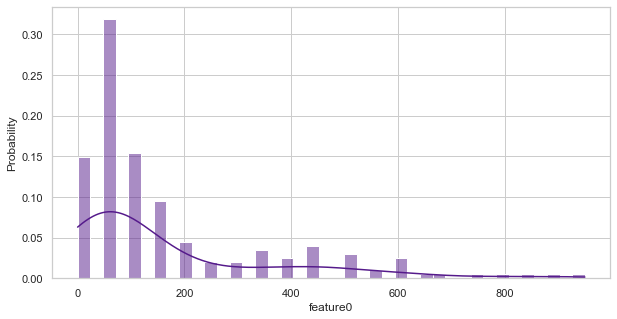

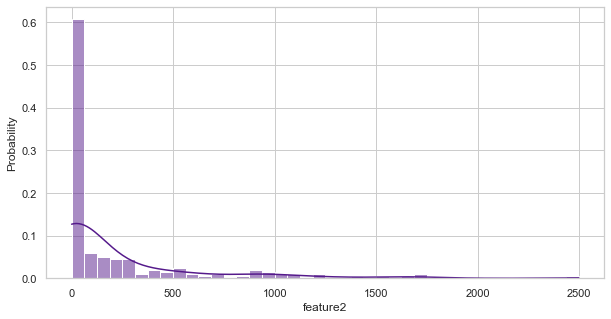

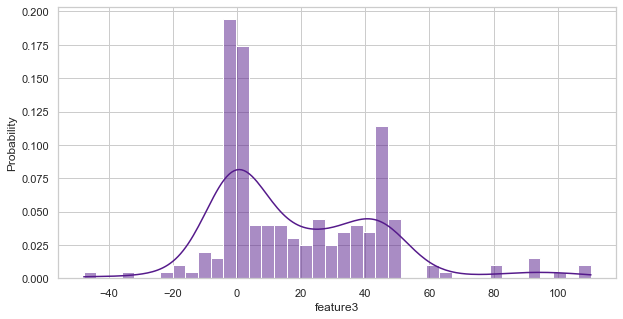

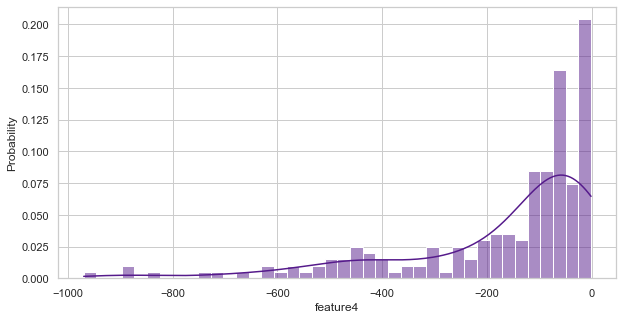

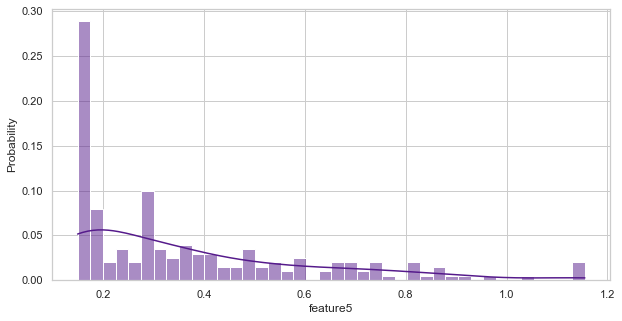

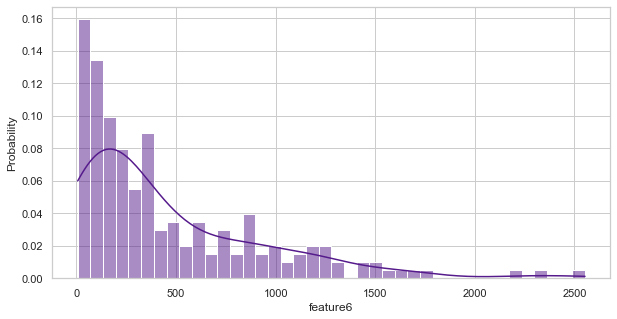

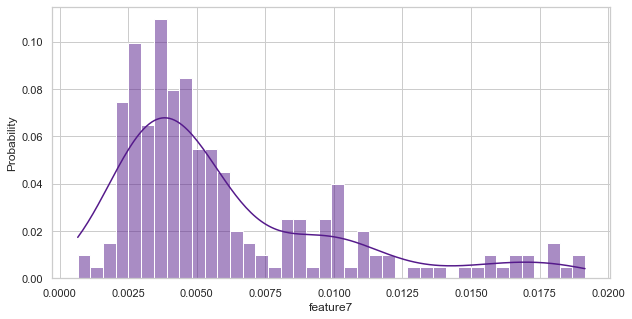

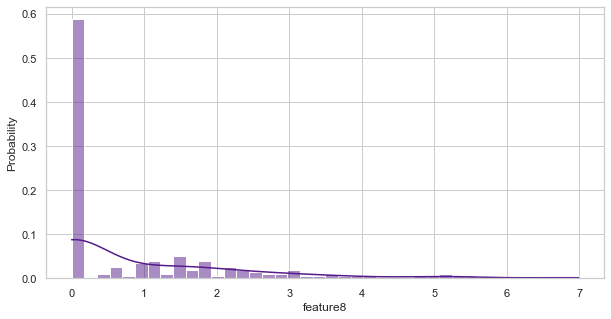

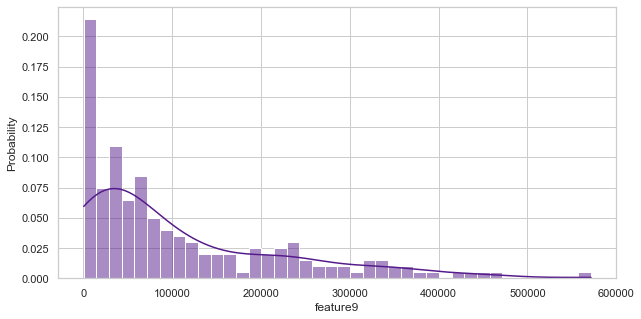

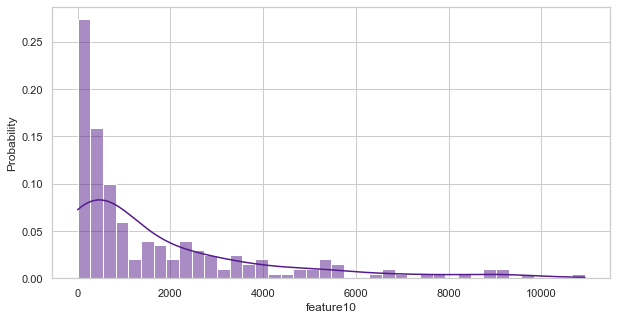

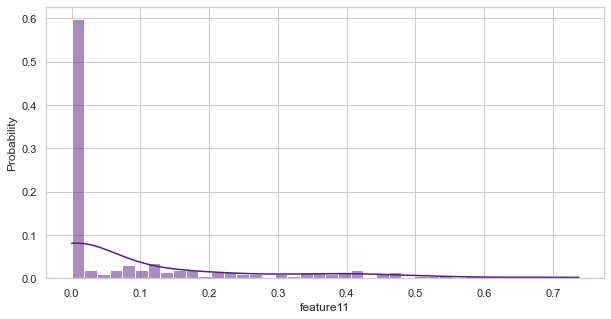

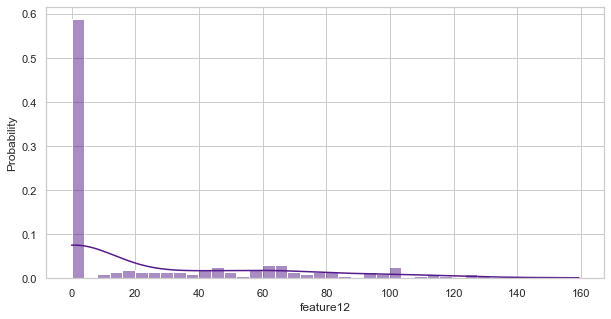

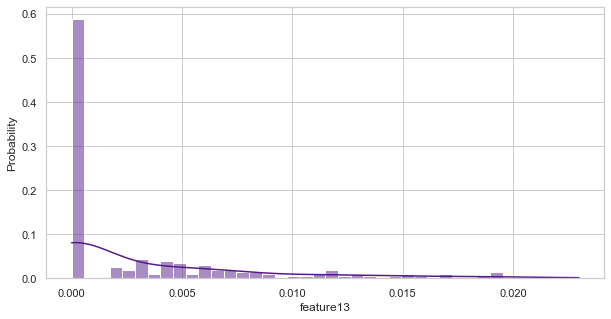

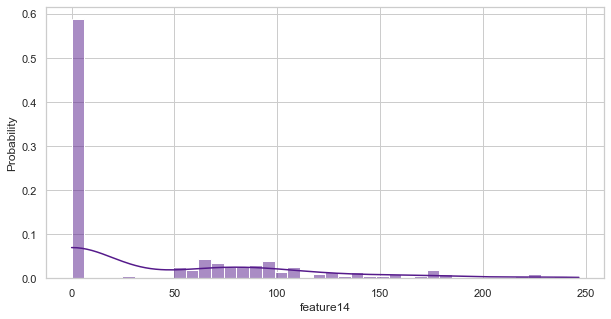

In [26]:
for column in features_numericas:
    plt.figure(figsize = (10, 5))
    sns.histplot(df[column], 
                 bins = 40,
                 stat = 'probability',
                 kde = True, 
                 color = '#551A8B')

Como podemos analisar, nenhuma das features apresenta distribuição normal. Essa é uma informação importante a ser considerada ao escolher um modelo de ML, visto que alguns deles têm a normalidade dos dados como requisito.

Como não temos informações sobre as variáveis, não podemos criar hipóteses que relacionem alguma delas, então não faremos análise bivariada separadamente.

## Análise multivariada

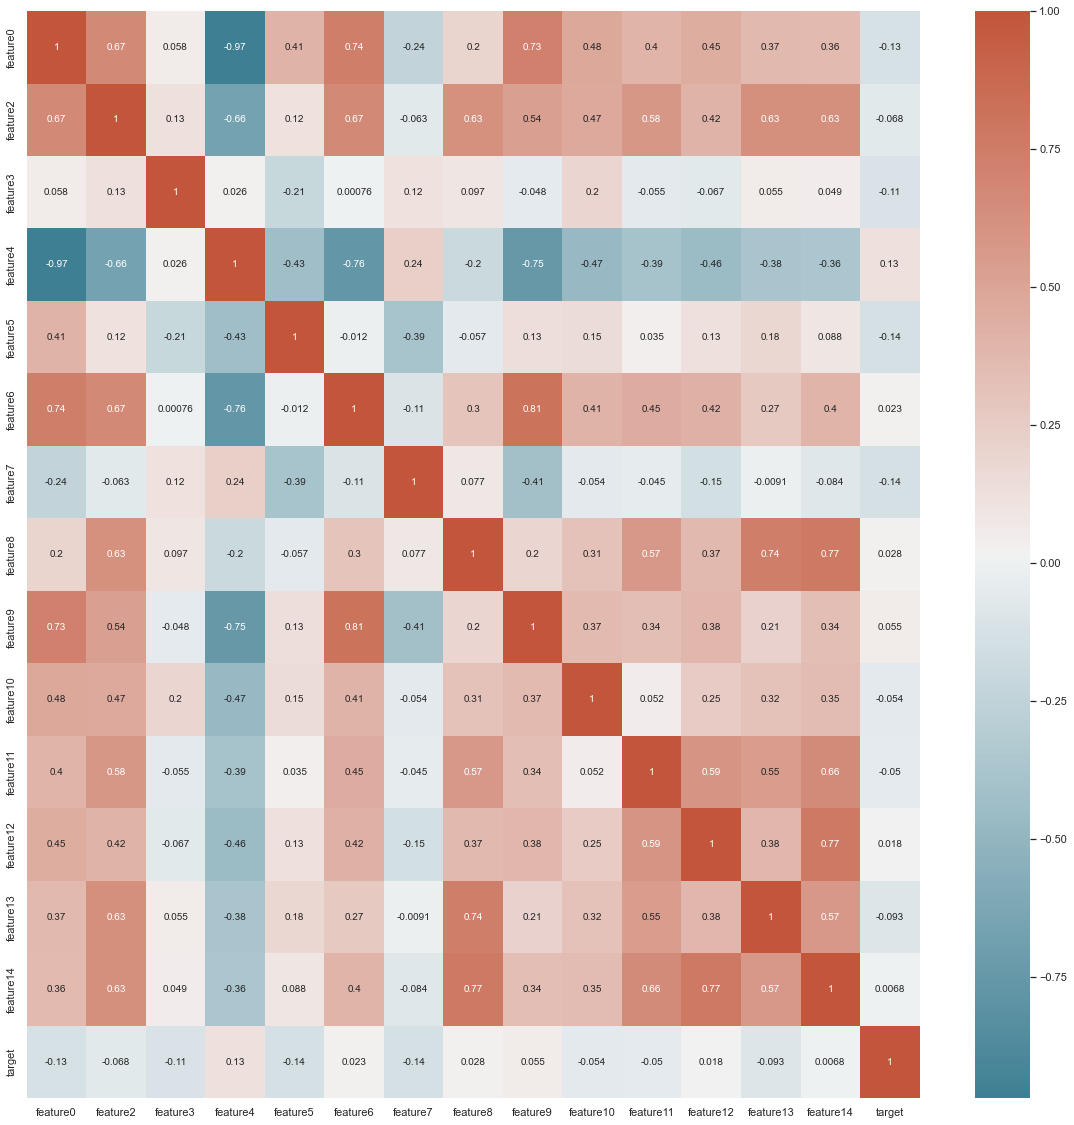

In [27]:
#Verificando correlação entre variáveis

corr = df.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))
plt.show()

Podemos observar que algumas variáveis possuem forte correlação entre si, como a feature0 e a feature4, com valor -0.96. Por enquanto não faremos nada em relação a isso, porém é mais uma informação que devemos considerar futuramente.

# Modelagem

In [28]:
#Separando os dados em X e y

X = df.drop('target', axis = 1)
y = df[['target']]

Optei pela métrica de acurácia para avaliar os modelos por três motivos:
1. As classes estão balanceadas
2. É uma métrica fácil de ser explicada
3. Não é informado se há uma "importância" para a classe positiva ou negativa

In [86]:
models = pd.DataFrame(columns = ['Modelo', 'Acurácia'])

In [87]:
lr = LogisticRegression(max_iter=1000, random_state=2)

lr_result = cross_val_score(cv = 10, estimator = lr, X = X.values, y = y.values.ravel(), scoring = 'accuracy').mean()

models = models.append({'Modelo': 'Regressão Logística', 'Acurácia': lr_result}, ignore_index=True)

In [88]:
svc = SVC(random_state=2)

svc_result = cross_val_score(cv = 10, estimator = svc, X = X, y = y.values.ravel(), scoring = 'accuracy').mean()

models = models.append({'Modelo': 'SVC', 'Acurácia': svc_result}, ignore_index=True)

In [89]:
xgb = XGBClassifier(random_state=2)

xgb_result = cross_val_score(cv = 10, estimator = xgb, X = X.values, y = y.values.ravel(), scoring = 'accuracy').mean()

models = models.append({'Modelo': 'XGBoost Classifier', 'Acurácia': xgb_result}, ignore_index=True)

In [90]:
models

,Modelo,Acurácia
0,Regressão Logística,0.646667
1,SVC,0.686667
2,XGBoost Classifier,0.646905


Como podemos ver, não temos uma diferença muito grande entre os modelos. Porém, optei por seguir com o SVC, que apresentou melhor performance entre os escolhidos.

# Otimização

A otimização da performance de modelos de Machine Learning pode envolver, a mais "alto nível", duas possibilidades: melhorar os parâmetros do modelo ou melhorar a qualidade dos dados fornecidos.

Uma questão que foi discutida no início da análise foi que algumas features possuem bastante diferença entre as escalas. Isso é um problema para o SVM, pois ele utiliza distâncias. Então, faremos uma transformação nos dados para corrigir isso e verificar novamente a performance.

In [93]:
rkf = RepeatedKFold()

pipeline_svc = Pipeline([('scaler', MinMaxScaler()), ('svc', SVC(random_state=2))])

acuracias_svc = list()

for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

  #alterando a escala apenas dos dados de treino para não haver vazamento de dados

  pipeline_svc.fit(X_train, y_train)

  acuracias_svc.append(accuracy_score(y_test, pipeline_svc.predict(X_test)))

print(f'Acurácia para o SVC após normalização: {np.mean(acuracias_svc)}')

Acurácia para o SVC após normalização: 0.6787317073170732


Como podemos observar, houve uma perda na acurácia, então essa transformação não foi eficiente.

Outra observação sobre os dados que foi feita foi que algumas features são muito correlacionadas, e isso também pode afetar o SVM. Para tentar lidar com esse problema, uma estratégia é redução de dimensionalidade dos dados. Optei por usar o PCA, que opera melhor se aliado à normalização.

In [94]:
acuracias_svc_pca = list()
pca = PCA(n_components = 'mle')
scaler = MinMaxScaler()

for train_index, test_index in rkf.split(X):
  X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
  y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

  #alterando a escala apenas dos dados de treino para não haver vazamento de dados
  pca.fit(X_train)
  
  X_train_scaled = scaler.fit_transform(X_train.values)
  X_train_dim = pca.transform(X_train_scaled)

  X_test_dim = pca.transform(X_test)

  svc.fit(X_train_dim, y_train)

  acuracias_svc_pca.append(accuracy_score(y_test, svc.predict(X_test_dim)))

print(f'Acurácia para o SVC após PCA: {np.mean(acuracias_svc_pca)}')

Acurácia para o SVC após PCA: 0.6863414634146342


Fiz alguns testes de hiperparâmetros manualmente para o SVC. Não usei o RandomizedSearch do sklearn, pois não consegui executar em tempo hábil e não consegui descobrir o motivo disso. 

O resultado que obtive foi: mesmo mudando os hiperparâmetros, não houve mudanças significativas na acurácia, então optei por deixar o SVC com os parâmetros default. Não consegui melhorar a performance do modelo.